In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [2]:
import h5py
import numpy as np
import scipy as sp
import scipy.stats as stats
import nibabel as nibabel
import pandas as pd
import nibabel.freesurfer.mghformat as mgh
import scipy.io
import itertools 
import pickle

In [3]:
data_dir = '../../../data/'

In [4]:
subjid = ['01', '02', '03', '04', '05', '06', '07', '08']
ROI_names = ['Unknown', 'Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal']
n_repeats = 3

In [5]:
with open('rh_betas_by_repeat_by_ROI.data', 'rb') as filehandle:
    # read the data as binary data stream
    rh_betas_by_repeat_by_ROI = pickle.load(filehandle)

In [6]:
reliability = []
for sidx, sid in enumerate(subjid):
    
    sh_dir = '../../../local_data/freesurfer/subj' + sid + '/rh_split_half.mat'
    sh = scipy.io.loadmat(sh_dir)
    
    reliability.append(sh['mean'])


In [7]:
rh_streams = []
for sidx, sid in enumerate(subjid):
    mgh_file = mgh.load(data_dir+'nsddata/freesurfer/subj'+ sid +'/label/rh.streams.mgz')
    rh_streams.append(mgh_file.get_fdata()[:,0,0])

In [8]:
# let's organize by ROI 
sh_by_ROI = [[[] for j in range(len(ROI_names)-1)] for i in range(len(subjid))]
total_vox = np.zeros((len(subjid), len(ROI_names)-1))

for sidx, sid in enumerate(subjid):  
    for roi_idx in range(len(ROI_names)-1):       
        sh_by_ROI[sidx][roi_idx]=reliability[sidx][:,rh_streams[sidx] == roi_idx+1]
        total_vox[sidx,roi_idx] = len(sh_by_ROI[sidx][roi_idx][0])

In [9]:
sh_by_ROI

[[array([[0.08296778, 0.15602   , 0.16638921, ..., 0.31941372, 0.32617069,
          0.32628391]]),
  array([[0.09568497, 0.09712989, 0.08487972, ..., 0.21764836, 0.14083928,
          0.17424042]]),
  array([[0.23880662, 0.18585416, 0.26375971, ..., 0.09951638, 0.1005959 ,
          0.10273875]]),
  array([[0.03044186, 0.03475564, 0.05432139, ..., 0.26599555, 0.27784845,
          0.20177745]]),
  array([[ 0.30189053,  0.35963126,  0.32779382, ...,  0.00051493,
          -0.00087973,  0.00501137]]),
  array([[0.07262505, 0.10695776, 0.14063999, ..., 0.15585135, 0.17760853,
          0.12228662]]),
  array([[0.05349304, 0.04152601, 0.04213209, ..., 0.10318803, 0.1052054 ,
          0.10282099]])],
 [array([[0.01330934, 0.01319605, 0.01885947, ..., 0.11359837, 0.20414651,
          0.08803703]]),
  array([[0.24199754, 0.2538973 , 0.27795232, ..., 0.17830965, 0.20449652,
          0.20619038]]),
  array([[0.00635359, 0.00737841, 0.00234576, ..., 0.24978926, 0.2533982 ,
          0.255272

In [13]:
sum(sh_by_ROI[0][0][0]>.1)

9205

In [14]:
thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

In [42]:
num_vox_by_thresh = np.zeros((len(subjid), len(ROI_names)-1, len(thresholds)))
prop_vox_by_thresh = np.zeros((len(subjid), len(ROI_names)-1, len(thresholds)))


for sidx, sid in enumerate(subjid):  
    for roi_idx in range(len(ROI_names)-1):   
        for tidx, thresh in enumerate(thresholds):
            num_vox_by_thresh[sidx,roi_idx,tidx] = int(sum(sh_by_ROI[sidx][roi_idx][0]>thresh))
            prop_vox_by_thresh[sidx,roi_idx,tidx] = num_vox_by_thresh[sidx,roi_idx,tidx]/total_vox[sidx,roi_idx]



In [27]:
np.mean(num_vox_by_thresh[:][0][:],axis=0)

array([8335.42857143, 6294.85714286, 4821.71428571, 3784.42857143,
       2811.        , 1948.42857143, 1318.        ,  833.        ,
        473.28571429,  258.85714286,  130.57142857])

In [44]:
np.mean(prop_vox_by_thresh[:,0,:],axis=0)

array([0.99960619, 0.87847047, 0.68678322, 0.53446394, 0.39933326,
       0.2946815 , 0.20389336, 0.12697141, 0.06875853, 0.03290092,
       0.01585228])

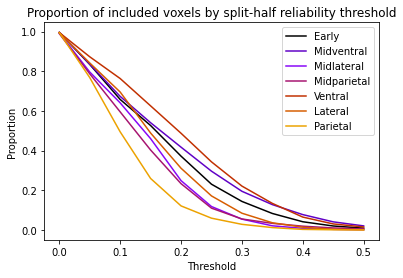

In [57]:

for roi_idx in range(len(ROI_names)-1):  
    color = plt.cm.gnuplot(roi_idx/(len(ROI_names)-1)) # r is 0 to 1 inclusive
    plt.plot(thresholds, 
             np.mean(prop_vox_by_thresh[:][roi_idx][:],axis=0), 
             label = ROI_names[roi_idx+1],color=color)
plt.xlabel('Threshold')
plt.ylabel('Proportion')
plt.title('Proportion of included voxels by split-half reliability threshold')
plt.legend()

plt.savefig('../../../results/figures/prop_vox_by_thresh.png')


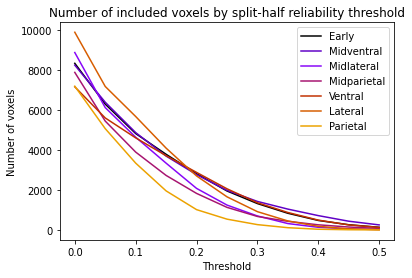

In [58]:
for roi_idx in range(len(ROI_names)-1):  
    color = plt.cm.gnuplot(roi_idx/(len(ROI_names)-1)) # r is 0 to 1 inclusive
    plt.plot(thresholds, 
             np.mean(num_vox_by_thresh[:][roi_idx][:],axis=0), 
             label = ROI_names[roi_idx+1],color=color)
plt.xlabel('Threshold')
plt.ylabel('Number of voxels')
plt.title('Number of included voxels by split-half reliability threshold')
plt.legend()

plt.savefig('../../../results/figures/num_vox_by_thresh.png')


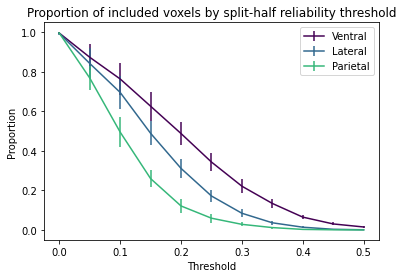

In [73]:
#higher order area zoom
for roi_idx in range(4,len(ROI_names)-1):  
    color = plt.cm.viridis((roi_idx-4)/3) 
    plt.errorbar(thresholds, 
             np.mean(prop_vox_by_thresh[:][roi_idx][:],axis=0), 
             stats.sem(prop_vox_by_thresh[:][roi_idx][:],axis=0), 
             label = ROI_names[roi_idx+1],color=color)
plt.xlabel('Threshold')
plt.ylabel('Proportion')
plt.title('Proportion of included voxels by split-half reliability threshold')
plt.legend()

plt.savefig('../../../results/figures/prop_vox_by_thresh_higher_only.png')


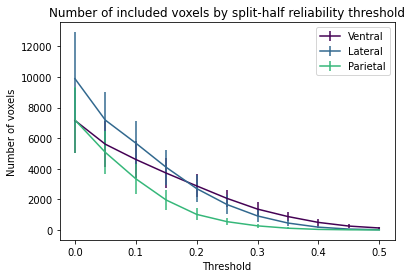

In [71]:
for roi_idx in range(4,len(ROI_names)-1):  
    color = plt.cm.viridis((roi_idx-4)/3) # r is 0 to 1 inclusive
    plt.errorbar(thresholds, 
             np.mean(num_vox_by_thresh[:][roi_idx][:],axis=0), 
             stats.sem(num_vox_by_thresh[:][roi_idx][:],axis=0), 
             label = ROI_names[roi_idx+1],color=color)
plt.xlabel('Threshold')
plt.ylabel('Number of voxels')
plt.title('Number of included voxels by split-half reliability threshold')
plt.legend()

plt.savefig('../../../results/figures/num_vox_by_thresh_higher_Only.png')
